#  This is Lab 3 executable file
This file contains the program code that is the solution to the tasks from the file [lab_3_task.txt](https://github.com/vandosik/M-M-MSA/blob/master/Lab_3/lab_3_task.txt).
## Authors
* Ivan Dubinin: [vandosik](https://github.com/vandosik)
* Alexey Grandilevskii: [zer0deck](https://github.com/zer0deck)
* Mikhail Sorokin: [Mikha1lSorokin](https://github.com/Mikha1lSorokin)

In [2]:
#Libraries initialization 
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pylab


## Step 1.
Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 – target variables, the rest - predictors).

In [13]:
# Dataset initialization
path_to_file = '../Datasets/Challenger_Ranked_Games.csv'
source_df = pd.read_csv(path_to_file, engine='python')

# Used features and data preparation
source_df = source_df[[ 'blueTotalHeal', # 1st target variable
                        'blueTotalGold', # 2nd target variable
                        'blueChampionDamageDealt', # 3rd target variable
                        'blueTotalMinionKills', # This and the rest are predictors
                        'blueWardPlaced',
                        'gameDuraton',
                        'blueWardkills', 
                        'blueKills', 
                        'blueDeath', 
                        'blueJungleMinionKills',
                        'blueObjectDamageDealt',
                        'blueWins']]

# Removing outliers
for col_name in source_df:
    if True: # cut by quantiles
        # Default ones
        up_quant = 0.999
        down_quant = 0.001

        if col_name == 'blueTotalGold':
            down_quant = 0.005
        elif col_name == 'blueTotalMinionKills':
            down_quant = 0.005
        if col_name != 'blueWins':
            q_low = source_df[col_name].quantile(down_quant)
            q_hi  = source_df[col_name].quantile(up_quant)

            source_df = source_df[(source_df[col_name] < q_hi) & (source_df[col_name] > q_low)]
    else: # cut by zscore
        source_df[(np.abs(scipy.stats.zscore(source_df)) < 3).all(axis=1)]

targets_df = source_df.iloc[:, :3].copy()
predictors_df = source_df.iloc[:, 3:].copy()

print('Targets:')
targets_df.head(5)


Targets:


,blueTotalHeal,blueTotalGold,blueChampionDamageDealt
0,31.035,37.001,56.039
1,26.397,41.072,60.243
2,6.567,22.929,24.014
3,24.718,63.447,101.607
4,37.161,74.955,134.826


In [15]:
print('Predictors:')
predictors_df.head(5)

Predictors:


,blueTotalMinionKills,blueWardPlaced,gameDuraton,blueWardkills,blueKills,blueDeath,blueJungleMinionKills,blueObjectDamageDealt,blueWins
0,440,38,22.050000,13,15,31,105,5.675,0
1,531,57,21.950000,18,19,8,111,45.303,1
2,306,28,15.533333,7,5,20,64,5.651,0
3,774,129,34.966667,39,26,36,226,31.019,0
4,831,114,39.066667,35,27,40,252,95.287,1


## Used variables explanation
> Here is a very brief summary of the values ​​used. 
> Details are contained in the [README.MD](https://github.com/vandosik/M-M-MSA/blob/master/Datasets/README.MD) file in the datasets folder.
1. gameDuraton: This value indicates the duration of the match and is the main investigated value in the second laboratory work. It is calculated as the difference between the start and end timestamps of the match.
2. blueWins: An integer number of wins for the blue team.
3. blueWardPlaced: Ward is a special item in the game that is used to increase the visibility of the game map.
4. blueWardkills: Blue team number of wards destroyed.
5. blueKills: Blue team kills.
6. blueDeath: Blue team deaths.
7. blueChampionDamageDealt: The sum of units of damage inflicted on opponents.
8. blueTotalGold: The amount of in-game currency earned by the team.
9. blueTotalMinionKills: Number of NPCs killed by the blue team.
10. blueJungleMinionKills: Number of Jungle NPCs killed by the blue team. 
11. blueTotalHeal: The amount of health earned by the team.
12. blueObjectDamageDealt: The sum of units of damage inflicted on enemy buildings.

## Step 2.
Using univariate parametric distributions that were fitted in Lab#2 (or Lab#1) make sampling of chosen target variables. Use for this 2 different sampling methods.

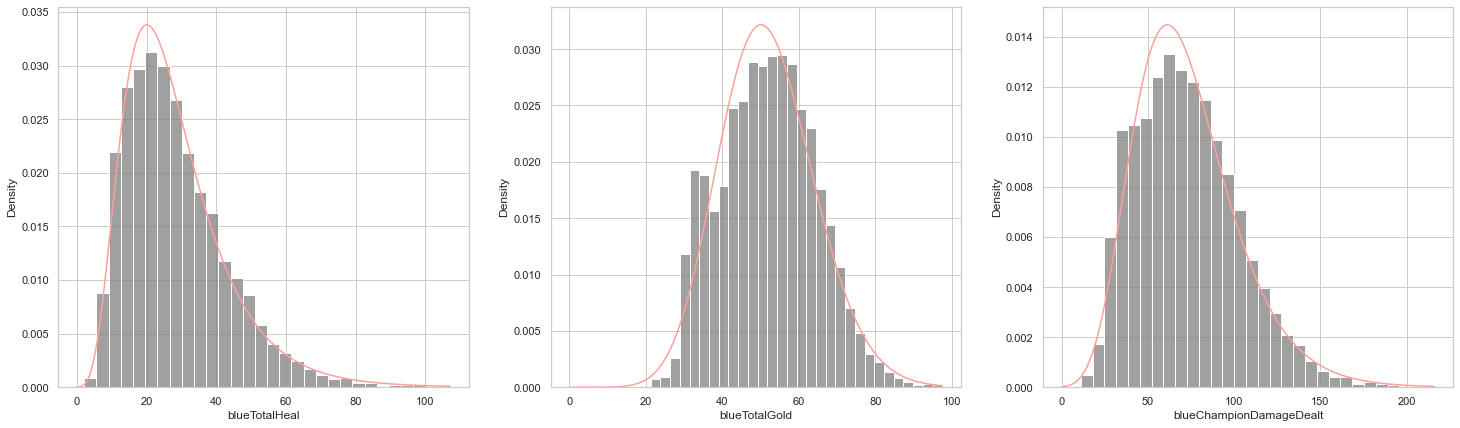

In [6]:
# Bring 3 target univariate parametric distributions from Lab 1
sns.set_theme(style='whitegrid', palette='pastel')
fig, axes = plt.subplots(1, 3, figsize=(25, 7))
for i, col_name in enumerate(targets_df):
    sns.histplot(source_df[col_name], kde=False, bins=30, stat='density', ax=axes[i], palette='Set3', color = 'grey')
    max_amount = targets_df[col_name].max()
    x = np.linspace(0, max_amount, 1000)

    if col_name == 'blueChampionDamageDealt' or col_name == 'blueTotalHeal':
        # The lognorm distribution parameters are determined using the fit function based on the maximum likelihood method
        mle_params = sp.stats.lognorm.fit(source_df[col_name], loc=1.1, scale=1.1) # Make initial Guess
        pdf_mle = sp.stats.lognorm.pdf(x, *mle_params)

    elif col_name == 'blueTotalGold':
        mle_params = sp.stats.chi2.fit(source_df[col_name])
        pdf_mle = sp.stats.chi2.pdf(x, *mle_params)
    
    axes[i].plot(x, pdf_mle, color='r')

C:\Users\Professional\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:1302: RuntimeWarning: invalid value encountered in subtract
  return sc.xlogy(df/2.-1, x) - x/2. - sc.gammaln(df/2.) - (np.log(2)*df)/2.


<AxesSubplot:xlabel='blueChampionDamageDealt', ylabel='Density'>

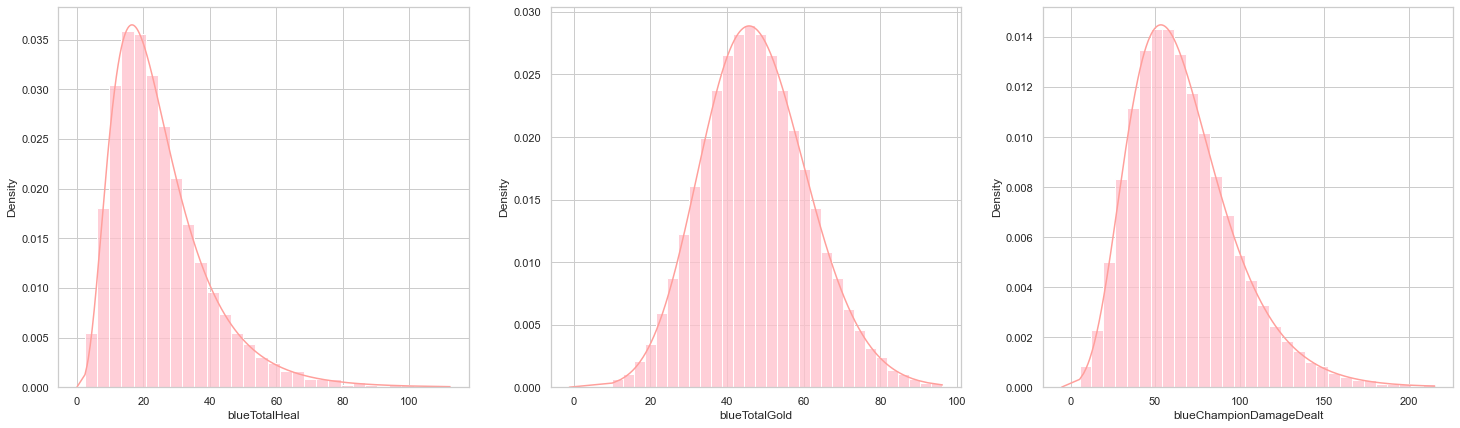

In [23]:
# Inverse transform sampling
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

params_1 = sp.stats.lognorm.fit(targets_df['blueTotalHeal'], loc=1.1, scale=1.1)
x = np.linspace(0.001, 100, 1000)
ppf_1 = sp.stats.lognorm.ppf(x / 100.0, *params_1)
pdf_1 = sp.stats.lognorm.pdf(ppf_1, *params_1)
axes[0].plot(ppf_1, pdf_1 , 'r')
axes[0].set(xlabel='blueTotalHeal')
synthetic_data=ppf_1[1:ppf_1.size-1]
sns.histplot(synthetic_data, kde=False, bins=30, stat='density', ax=axes[0], palette='Set3', color = 'pink')

params_2 = sp.stats.chi2.fit(targets_df['blueTotalGold'])
x = np.linspace(0.001, 100, 1000)
ppf_2 = sp.stats.chi2.ppf(x / 100.0, *params_2)
pdf_2 = sp.stats.chi2.pdf(ppf_2, *params_2)
axes[1].plot(ppf_2, pdf_2 , 'r')
axes[1].set(xlabel='blueTotalGold')
synthetic_data=ppf_2[1:ppf_2.size-1]
sns.histplot(synthetic_data, kde=False, bins=30, stat='density', ax=axes[1], palette='Set3', color = 'pink')

params_3 = sp.stats.lognorm.fit(targets_df['blueChampionDamageDealt'], loc=1.1, scale=1.1)
x = np.linspace(0.001, 100, 1000)
ppf_3 = sp.stats.lognorm.ppf(x / 100.0, *params_3)
pdf_3 = sp.stats.lognorm.pdf(ppf_3, *params_3)
axes[2].plot(ppf_3, pdf_3 , 'r')
axes[2].set(xlabel='blueChampionDamageDealt')
synthetic_data=ppf_3[1:ppf_3.size-1]
sns.histplot(synthetic_data, kde=False, bins=30, stat='density', ax=axes[2], palette='Set3', color = 'pink')

[Text(0.5, 0, 'blueChampionDamageDealt'), Text(0, 0.5, 'Density')]

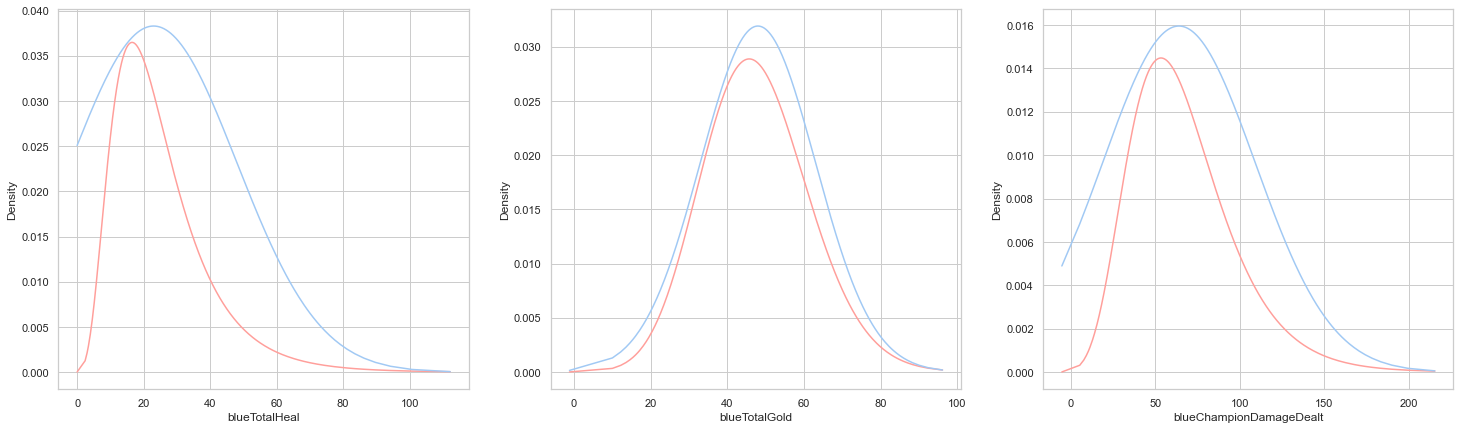

In [24]:
# Accept-Reject sampling

# Gaussian PDF
def gaussian(x, mu, sigma):
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

# Lognormal PDF
def lognormal(x, s):
    return 1/(s*x*np.sqrt(2*np.pi)) * np.exp(-np.log(x)**2/(2*s**2))

fig, axes = plt.subplots(1, 3, figsize=(25, 7))

gaussian_1 = gaussian(ppf_1, 23, 25)
multiplier = 2.4
axes[0].plot(ppf_1, pdf_1 , 'r')
axes[0].plot(ppf_1, multiplier * gaussian_1 , 'b')
axes[0].set(xlabel='blueTotalHeal', ylabel='Density')

gaussian_2 = gaussian(ppf_2, 48, 15)
multiplier = 1.2
axes[1].plot(ppf_2, pdf_2 , 'r')
axes[1].plot(ppf_2, multiplier * gaussian_2 , 'b')
axes[1].set(xlabel='blueTotalGold', ylabel='Density')

gaussian_3 = gaussian(ppf_3, 64, 45)
multiplier = 1.8
axes[2].plot(ppf_3, pdf_3 , 'r')
axes[2].plot(ppf_3, multiplier * gaussian_3 , 'b')
axes[2].set(xlabel='blueChampionDamageDealt', ylabel='Density')

[Text(0.5, 0, 'blueChampionDamageDealt'), Text(0, 0.5, 'Density')]

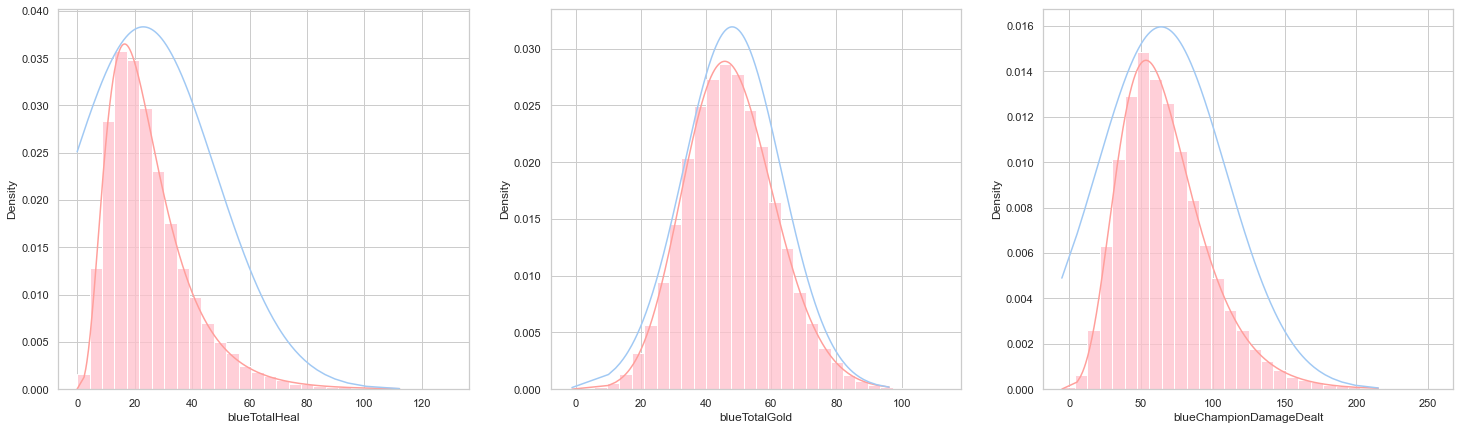

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

#number of instances
N = 100000
samples_1 = []
multiplier = 2.4
for _ in range(N):
    candidate = np.random.normal(23, 25)
    prob_accept = sp.stats.lognorm.pdf(candidate, *params_1) / (multiplier * gaussian(candidate, 23, 25))
    #accept with the calculated probability
    if np.random.random() < prob_accept:
        samples_1.append(candidate)

sns.histplot(samples_1, kde=False, bins=30, stat='density', ax=axes[0], palette='Set3', color = 'pink')
axes[0].plot(ppf_1, pdf_1 , 'r')
axes[0].plot(ppf_1, multiplier * gaussian_1 , 'b')
axes[0].set(xlabel='blueTotalHeal', ylabel='Density')

samples_2 = []
multiplier = 1.2
for _ in range(N):
    candidate = np.random.normal(48, 15)
    prob_accept = sp.stats.chi2.pdf(candidate, *params_2) / (multiplier * gaussian(candidate, 48, 15))
    #accept with the calculated probability
    if np.random.random() < prob_accept:
        samples_2.append(candidate)

sns.histplot(samples_2, kde=False, bins=30, stat='density', ax=axes[1], palette='Set3', color = 'pink')
axes[1].plot(ppf_2, pdf_2 , 'r')
axes[1].plot(ppf_2, multiplier * gaussian_2 , 'b')
axes[1].set(xlabel='blueTotalGold', ylabel='Density')

samples_3 = []
multiplier = 1.8
for _ in range(N):
    candidate = np.random.normal(64, 45)
    prob_accept = sp.stats.lognorm.pdf(candidate, *params_3) / (multiplier * gaussian(candidate, 64, 45))
    #accept with the calculated probability
    if np.random.random() < prob_accept:
        samples_3.append(candidate)

sns.histplot(samples_3, kde=False, bins=30, stat='density', ax=axes[2], palette='Set3', color = 'pink')
axes[2].plot(ppf_3, pdf_3 , 'r')
axes[2].plot(ppf_3, multiplier * gaussian_3 , 'b')
axes[2].set(xlabel='blueChampionDamageDealt', ylabel='Density')

## Step 3.
Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients. 

<AxesSubplot:>

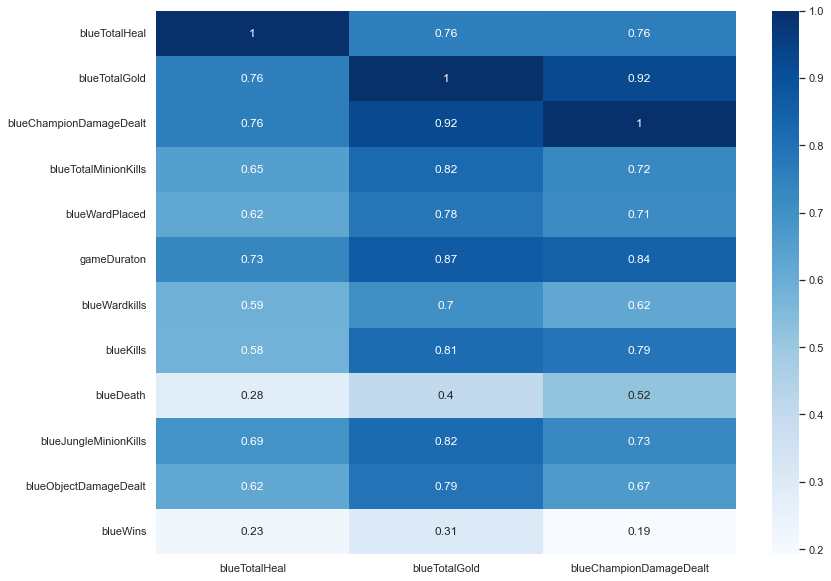

In [16]:
# Correlation coefficients
fig, axes = plt.subplots(1, 1, figsize=(13, 10))
sns.heatmap(source_df.corr()[['blueTotalHeal','blueTotalGold','blueChampionDamageDealt']], cmap='Blues', annot=True)